In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve 

# We split the data into training, testing and validation sets

In [2]:
df = pd.read_csv("cleanedv1.csv")
df = df.dropna()
df["is_not_A"] = df["score"] > 14
df["is_not_A"] = df["is_not_A"].astype(int)
df["month"] = df["month"].astype(str)
df_cleaned = df[["inspection_count","std_yelp_review_count","std_chain_size","yelp_price","month","overnight","is_not_A"]]
df_cleaned = pd.get_dummies(df_cleaned)
train, test = train_test_split(df_cleaned, test_size=0.2, random_state=1)
train, validation = train_test_split(train, test_size=0.2, random_state=1)
train_x = train.drop(columns=["is_not_A"])
test_x = test.drop(columns=["is_not_A"])
validation_x = validation.drop(columns=["is_not_A"])


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# We start with a logistic regression but only get limited results

In [5]:
regr = linear_model.LogisticRegression()
regr.fit(train_x, train["is_not_A"])
predicted_test_y = regr.predict(test_x)

In [6]:
print(classification_report(test["is_not_A"], predicted_test_y))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      1191
          1       0.45      0.04      0.07       140

avg / total       0.85      0.89      0.85      1331



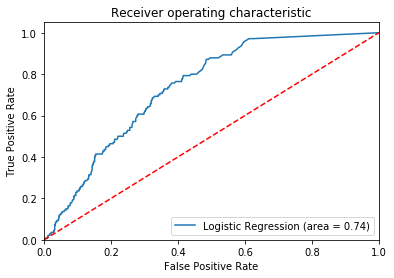

In [23]:
logit_roc_auc = roc_auc_score(test["is_not_A"], predicted_test_y)
fpr, tpr, thresholds = roc_curve(test["is_not_A"], predicted_test_y)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('log_ROC')
plt.show()

# A random forest gives us much better results although it is not interpretable

In [8]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
train.columns
rf.fit(train_x, train["is_not_A"]);

AUC is: 0.736739834472832


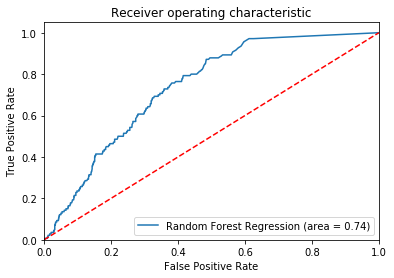

In [24]:
predicted_test_y = rf.predict(test_x)
rf_roc_auc = roc_auc_score(test["is_not_A"], predicted_test_y)
print("AUC is:",rf_roc_auc)
fpr, tpr, thresholds = roc_curve(test["is_not_A"], predicted_test_y)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_test_ROC')
plt.show()

AUC is: 0.7721231965261242


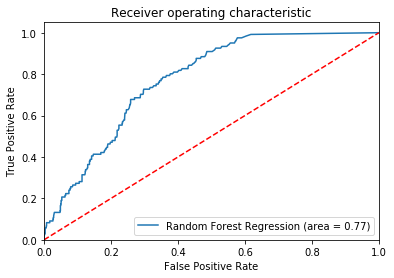

In [25]:
predicted_validation_y = rf.predict(validation_x)
rf_roc_auc = roc_auc_score(validation["is_not_A"], predicted_validation_y)
print("AUC is:",rf_roc_auc)
fpr, tpr, thresholds = roc_curve(validation["is_not_A"], predicted_validation_y)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_validation_ROC')
plt.show()

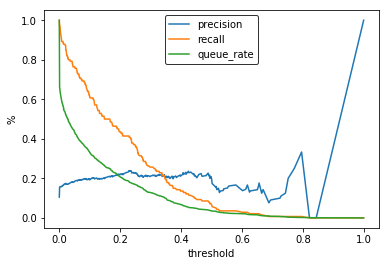

In [11]:
import seaborn as sns

precision, recall, thresholds = precision_recall_curve(test["is_not_A"], predicted_test_y) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 
for threshold in thresholds: 
    queue_rate.append((predicted_test_y >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')
plt.savefig("precision-recall")

In [12]:
df = pd.DataFrame({"thresholds":thresholds,"precision":precision,"recall":recall})

In [19]:
df[df["thresholds"]>0]

,thresholds,precision,recall
1,0.000667,0.154370,0.971429
2,0.001000,0.154545,0.971429
3,0.002000,0.157225,0.971429
4,0.002667,0.158392,0.957143
5,0.003000,0.158580,0.957143
6,0.004000,0.157452,0.935714
7,0.004767,0.157959,0.928571
8,0.005000,0.158151,0.928571
9,0.005867,0.158220,0.914286
10,0.006000,0.158416,0.914286
